In [10]:
import os
from gensim.test.utils import datapath

tmp = datapath(os.getcwd() + '\\tmp\\model.ldamodel')

In [6]:
import json

with open('nouns_adj.json', 'r') as f:
    documents = json.load(f)

### Filter out tokens by frequency

In [7]:
from gensim import corpora

# Map each token to a unique ID
dictionary = corpora.Dictionary(documents)
print(f'Number of unique tokens: {len(dictionary)}')

# Filter out words that occur in less than 15 documents
# or more than 30% of the documents
min_doc, max_doc = 15, .3
dictionary.filter_extremes(no_below=min_doc, no_above=max_doc)
print(f'Number of unique tokens (filtered): {len(dictionary)}')

# Create a bag of words corpus
corpus = [dictionary.doc2bow(doc) for doc in documents]
print(f'Number of documents: {len(corpus)}')

Number of unique tokens: 30281
Number of unique tokens (filtered): 3346
Number of documents: 1260


### Build an LDA topic model

In [8]:
from gensim.models import CoherenceModel, LdaModel

# Set training parameters for LDA
num_topics = 15
random_state = 100
chunksize = len(corpus)
passes = 150
alpha = .9099999999999999
eta = .9099999999999999
iterations = 100
eval_every = 5

In [9]:
# Run LDA using Bag of Words
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, \
                     random_state=random_state, chunksize=chunksize, \
                     passes=passes, alpha=alpha, eta=eta, iterations=iterations, \
                     eval_every=eval_every)

In [13]:
# Save the model
lda_model.save(tmp)

In [14]:
# Load the model
lda_model = LdaModel.load(tmp)

### Print the results

In [11]:
from pprint import pprint

top_topics = lda_model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics 
# divided by the number of topics
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print(f'\nAverage topic coherence: {avg_topic_coherence}')

pprint(lda_model.print_topics(num_words=15))


Average topic coherence: -1.5300470256920338
[(0,
  '0.016*"аппарат" + 0.013*"астероид" + 0.012*"планета" + 0.012*"высота" + '
  '0.011*"изображение" + 0.010*"объект" + 0.010*"спутник" + '
  '0.010*"космический" + 0.009*"орбита" + 0.008*"метр" + 0.008*"информация" + '
  '0.008*"зонд" + 0.007*"атмосфера" + 0.007*"движение" + 0.006*"титан"'),
 (1,
  '0.027*"днк" + 0.018*"древний" + 0.017*"геном" + 0.010*"кость" + '
  '0.009*"возраст" + 0.009*"фрагмент" + 0.008*"сапиенс" + 0.008*"неандерталец" '
  '+ 0.008*"слой" + 0.007*"пещера" + 0.007*"популяция" + 0.007*"генетический" '
  '+ 0.007*"предок" + 0.007*"человеческий" + 0.006*"находка"'),
 (2,
  '0.028*"звезда" + 0.023*"масса" + 0.014*"галактика" + 0.012*"чёрный_дыра" + '
  '0.011*"вселенная" + 0.009*"наблюдение" + 0.009*"солнечный" + '
  '0.008*"излучение" + 0.008*"солнце" + 0.007*"звёздный" + 0.007*"космический" '
  '+ 0.007*"астроном" + 0.007*"ядро" + 0.006*"дыра" + 0.006*"телескоп"'),
 (3,
  '0.018*"температура" + 0.012*"молекула" + 0.

### Evaluate topic coherence

In [12]:
# Compute perplexity
print(f'Perplexity:', lda_model.log_perplexity(corpus)) # the lower the better

# Compute coherence score using CV
coherence_c_v_model = CoherenceModel(model=lda_model, texts=documents, 
                                     dictionary=dictionary, coherence='c_v')
coherence_c_v = coherence_c_v_model.get_coherence()
print(f'Coherence score (c_v): {coherence_c_v}') # 0.5 is good, 0.6 is excellent

# Compute coherence score using UMass
coherence_umass_model = CoherenceModel(model=lda_model, texts=documents, 
                                       dictionary=dictionary, coherence="u_mass")
coherence_umass = coherence_umass_model.get_coherence()
print(f'Coherence score (UMass): {coherence_umass}') # should be close to 0

Perplexity: -7.052810484794077
Coherence score (c_v): 0.6937904631155565
Coherence score (UMass): -1.5300470256920338


### Visualize the topics

In [45]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
lda_display = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

### Extract the dominant topic for each document

In [43]:
import pandas as pd

def format_topics_sentences(lda_model=None, corpus=corpus, texts=documents):
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(lda_model[corpus]):
        row = row_list[0] if lda_model.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j != 0:  continue
            else:
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ', '.join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),
                                                                  round(prop_topic, 4),
                                                                  topic_keywords]), ignore_index=True)
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(lda_model=lda_model, corpus=corpus, texts=documents)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,14.0,0.9230,"затмение, луна, полный, фаза, солнце, полоса, ...","[март, год, полный, солнечный_затмение, полный..."
1,1,14.0,0.9531,"затмение, луна, полный, фаза, солнце, полоса, ...","[сентябрь, полный, лунный_затмение, европейски..."
2,2,14.0,0.9512,"затмение, луна, полный, фаза, солнце, полоса, ...","[март, год, полный, солнечный_затмение, полный..."
3,3,14.0,0.9675,"затмение, луна, полный, фаза, солнце, полоса, ...","[июль, год, продолжительный, нынешний, столети..."
4,4,14.0,0.9854,"затмение, луна, полный, фаза, солнце, полоса, ...","[первый, упоминание, солнечный_затмение, год, ..."
...,...,...,...,...,...
1255,1255,7.0,0.6562,"энергия, электрон, квантовый, свет, физика, по...","[группа, физик, гарвардский, техасский_универс..."
1256,1256,3.0,0.9222,"температура, молекула, атом, материал, магнитн...","[иранский, физика, эксперимент, вращение, плён..."
1257,1257,3.0,0.8561,"температура, молекула, атом, материал, магнитн...","[физик, новый, тип, сверхпроводник, общий, хим..."
1258,1258,3.0,0.4133,"температура, молекула, атом, материал, магнитн...","[исследователь, бордо, франция, вихрь, определ..."


### Show frequency distribution of word counts in documents

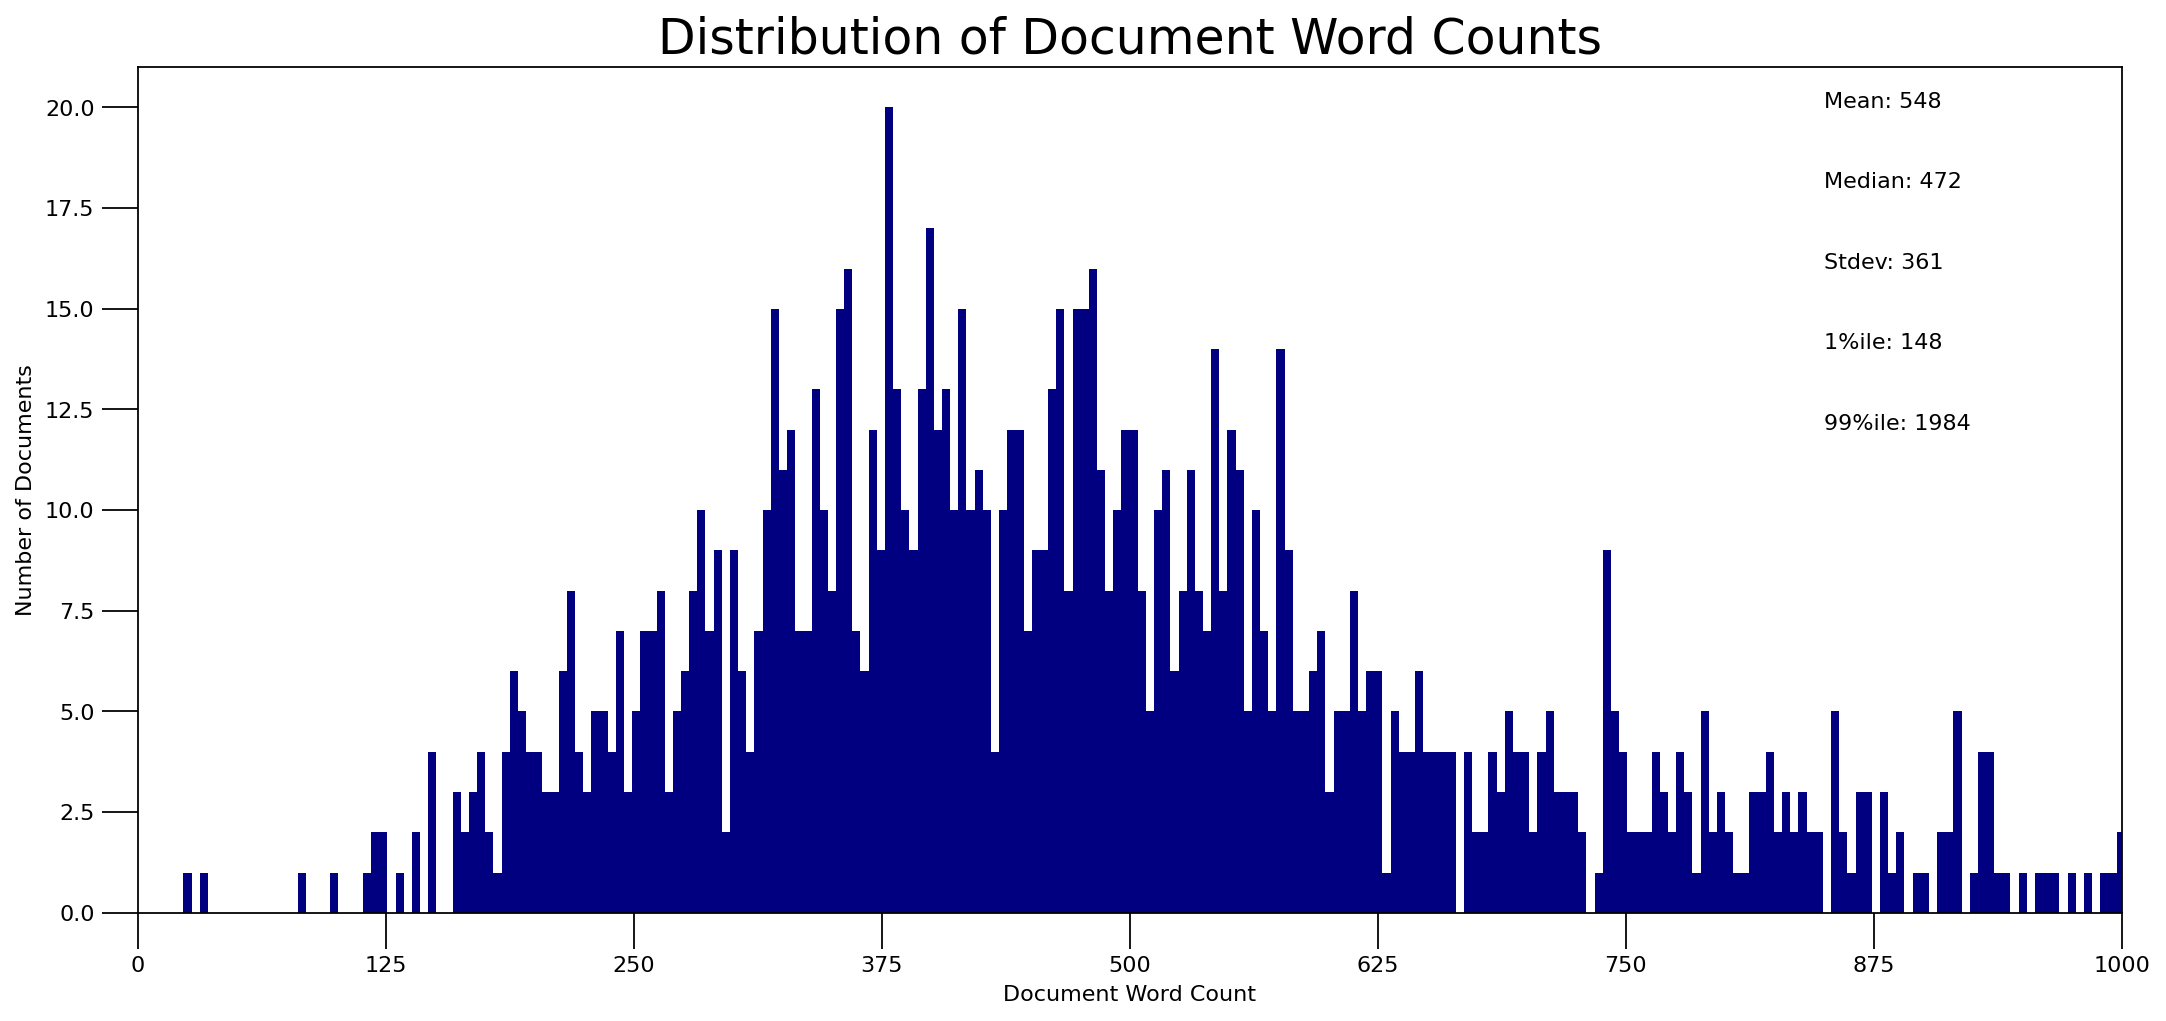

In [39]:
import matplotlib.pyplot as plt
import numpy as np

doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins=1000, color='navy')
plt.text(850, 20, "Mean: " + str(round(np.mean(doc_lens))))
plt.text(850, 18, "Median: " + str(round(np.median(doc_lens))))
plt.text(850, 16, "Stdev: " + str(round(np.std(doc_lens))))
plt.text(850, 14, "1%ile: " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(850, 12, "99%ile: " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0, 1000, 9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()